In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162728 sha256=cfbd8cdaedf388e770dd0cc383835e74e240fbcaf74240a459221ac6d5363125
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [4]:
from surprise import Dataset as SurpriseDataset, Reader as SurpriseReader, accuracy
from surprise.model_selection import cross_validate as model_cross_validate, train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVD as SingularValueDecomposition
from surprise.prediction_algorithms.knns import KNNBasic as BasicKNNNeighbors
import matplotlib.pyplot as plt

ratings_file_path = 'ratings_small.csv'
custom_reader = SurpriseReader(line_format='user item rating timestamp', sep=',', skip_lines=1)
ratings_data = SurpriseDataset.load_from_file(ratings_file_path, custom_reader)

In [5]:
# Models for evaluation
evaluation_models = [
    SingularValueDecomposition(),  # Probabilistic Matrix Factorization
    BasicKNNNeighbors(sim_options={'user_based': True}),  # User-based Collaborative Filtering
    BasicKNNNeighbors(sim_options={'user_based': False}),  # Item-based Collaborative Filtering
]

evaluation_metrics = ['mae', 'rmse']
for current_model in evaluation_models:
    print(f'\nModel: {current_model.__class__.__name__}')
    evaluation_results = model_cross_validate(current_model, ratings_data, measures=evaluation_metrics, cv=5, verbose=True)

    for metric in evaluation_metrics:
        avg_metric_value = sum(evaluation_results[f'test_{metric}']) / 5
        print(f'Average {metric}: {avg_metric_value}')


Model: SVD
Evaluating MAE, RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.6865  0.6980  0.6923  0.6894  0.6847  0.6902  0.0047  
RMSE (testset)    0.8931  0.9067  0.8995  0.8953  0.8889  0.8967  0.0061  
Fit time          1.36    1.81    1.43    1.35    1.38    1.47    0.17    
Test time         0.13    0.22    0.13    0.21    0.12    0.16    0.04    
Average mae: 0.690170424356672
Average rmse: 0.8966945832870369

Model: KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold

In [6]:
# Comparison of Average Performances
results_summary = {'model_type': [], 'mae': [], 'rmse': []}
for current_model in evaluation_models:
    model_label = 'PMF' if isinstance(current_model, SingularValueDecomposition) else 'User' if current_model.sim_options['user_based'] else 'Item'
    print('\n' + model_label)

    evaluation_results = model_cross_validate(current_model, ratings_data, measures=evaluation_metrics, cv=5, verbose=True)

    for metric in evaluation_metrics:
        avg_metric_value = sum(evaluation_results[f'test_{metric}']) / 5
        results_summary['model_type'].append(model_label)
        results_summary[metric].append(avg_metric_value)

for key, values in results_summary.items():
    print(f"{key}: {values}")

print("\nDetailed Comparison:")
for metric in evaluation_metrics:
    print(f"\nAverage {metric}:")
    for i in range(len(evaluation_models)):
        model_label = results_summary['model_type'][2*i]
        metric_value = results_summary[metric][i]
        print(f"{model_label}: {metric_value}")


PMF
Evaluating MAE, RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.6877  0.6922  0.6898  0.6878  0.6919  0.6899  0.0019  
RMSE (testset)    0.8944  0.8956  0.8939  0.8951  0.9015  0.8961  0.0028  
Fit time          1.35    1.29    1.30    1.30    1.28    1.30    0.02    
Test time         0.13    0.25    0.12    0.12    0.24    0.17    0.06    

User
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.7446  0.7441  0.7454  0.7460  0.7411  0.7

In [7]:
# Best model determination
best_rmse_model = results_summary['model_type'][results_summary['rmse'].index(min(results_summary['rmse']))]
best_mae_model = results_summary['model_type'][results_summary['mae'].index(min(results_summary['mae']))]

print(f"\nBest model based on RMSE: {best_rmse_model}")
print(f"Best model based on MAE: {best_mae_model}")

# Analysis of similarity metrics impact
similarity_options = ['cosine', 'msd', 'pearson']
model_types = ['user', 'item']
similarity_results = {}

for model_variant in model_types:
    similarity_results[model_variant] = {'mae': [], 'rmse': []}

    for sim_option in similarity_options:
        current_model = BasicKNNNeighbors(k=40, sim_options={'name': sim_option, 'user_based': model_variant == 'user'})
        model_evaluation = model_cross_validate(current_model, ratings_data, measures=['mae', 'rmse'], cv=5, verbose=True)

        for metric in ['mae', 'rmse']:
            avg_metric_value = sum(model_evaluation[f'test_{metric}']) / 5
            similarity_results[model_variant][metric].append(avg_metric_value)


Best model based on RMSE: PMF
Best model based on MAE: PMF
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.7687  0.7721  0.7723  0.7648  0.7653  0.7687  0.0032  
RMSE (testset)    0.9925  1.0009  0.9963  0.9909  0.9940  0.9949  0.0035  
Fit time          0.21    0.23    0.21    0.21    0.30    0.23    0.04    
Test time         1.52    1.40    1.41    2.16    1.47    1.59    0.29    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing

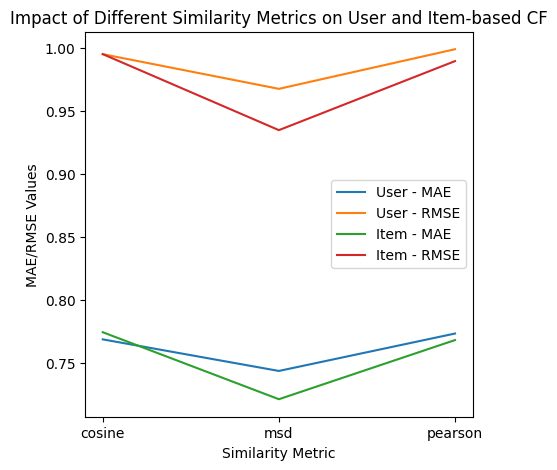

In [8]:
# Visualization of similarity impact
plt.figure(figsize=(5, 5))

for model_variant in model_types:
    plt.plot(similarity_options, similarity_results[model_variant]['mae'], label=f'{model_variant.capitalize()} - MAE')
    plt.plot(similarity_options, similarity_results[model_variant]['rmse'], label=f'{model_variant.capitalize()} - RMSE')

plt.title('Impact of Different Similarity Metrics on User and Item-based CF')
plt.xlabel('Similarity Metric')
plt.ylabel('MAE/RMSE Values')
plt.legend()
plt.show()


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.7513  0.7399  0.7511  0.7505  0.7514  0.7488  0.0045  
RMSE (testset)    0.9803  0.9688  0.9837  0.9874  0.9799  0.9800  0.0062  
Fit time          0.13    0.16    0.15    0.15    0.15    0.15    0.01    
Test time         1.01    1.04    1.11    1.04    1.02    1.05    0.04    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing s

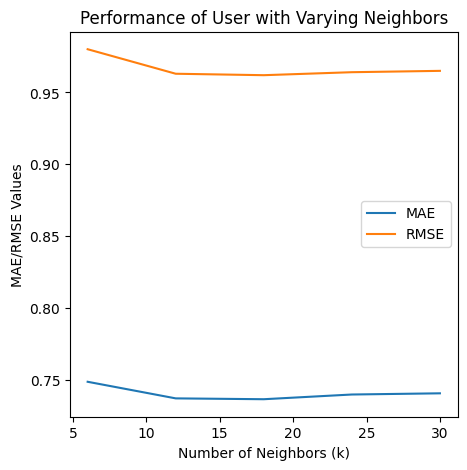

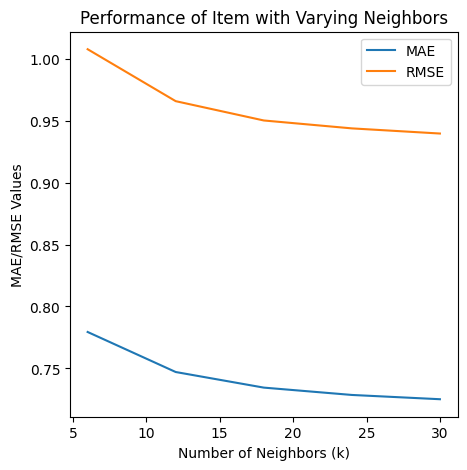

In [9]:
# Analysis of neighbors impact
neighborhood_sizes = [6, 12, 18, 24, 30]
neighborhood_effects = {'user': {'mae': [], 'rmse': []}, 'item': {'mae': [], 'rmse': []}}

for model_variant in ['user', 'item']:
    for k_value in neighborhood_sizes:
        current_model = BasicKNNNeighbors(k=k_value, sim_options={'user_based': model_variant == 'user'})
        neighborhood_evaluation = model_cross_validate(current_model, ratings_data, measures=['mae', 'rmse'], cv=5, verbose=True)
        for metric in evaluation_metrics:
            avg_metric_value = sum(neighborhood_evaluation[f'test_{metric}']) / 5
            neighborhood_effects[model_variant][metric].append(avg_metric_value)

for model_variant in ['user', 'item']:
    plt.figure(figsize=(5, 5))
    plt.plot(neighborhood_sizes, neighborhood_effects[model_variant]['mae'], label='MAE')
    plt.plot(neighborhood_sizes, neighborhood_effects[model_variant]['rmse'], label='RMSE')
    plt.title(f'Performance of {model_variant.capitalize()} with Varying Neighbors')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('MAE/RMSE Values')
    plt.legend()
    plt.show()

In [10]:
# Best K determination
best_k_user = neighborhood_sizes[neighborhood_effects['user']['rmse'].index(min(neighborhood_effects['user']['rmse']))]
best_k_item = neighborhood_sizes[neighborhood_effects['item']['rmse'].index(min(neighborhood_effects['item']['rmse']))]

print(f"\nOptimal Number of Neighbors for User-based CF: {best_k_user}")
print(f"Optimal Number of Neighbors for Item-based CF: {best_k_item}")



Optimal Number of Neighbors for User-based CF: 18
Optimal Number of Neighbors for Item-based CF: 30
